## ZIP model example

Source: https://stats.idre.ucla.edu/r/dae/zip/

**Data**: The state wildlife biologists want to model how many fish are being caught by fishermen at a state park. Visitors are asked how long they stayed, how many people were in the group, were there children in the group and how many fish were caught. Some visitors do not fish, but there is no data on whether a person fished or not. Some visitors who did fish did not catch any fish so there are excess zeros in the data because of the people that did not fish.

We have data on 250 groups that went to a park. Each group was questioned about how many fish they caught (count), how many children were in the group (child), how many people were in the group (persons), and whether or not they brought a camper to the park (camper).

In addition to predicting the number of fish caught, there is interest in predicting the existence of excess zeros, i.e., the probability that a group caught zero fish. 


We will use the variables child, persons, and camper in our model. Let’s look at the data.

## Checking the pytorch losses

### NLLLoss

source: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

- It is useful to train a classification problem with C classes.

- The input given through a forward call is expected to contain *log-probabilities* of each class. 
- input has to be a Tensor of size either $(minibatch, C)$ or $(minibatch, C, d_1, d_2, \dots, d_K)$ with $K \ge 1$ for the K-dimensional case. 

- Obtaining **log-probabilities** in a neural network is easily achieved by adding a *LogSoftmax* layer in the last layer of your network. 
- *You may use CrossEntropyLoss instead, if you prefer not to add an extra layer.*

- The target that this loss expects should be a class index in the range $[0, C−1]$ where $C$ = number of classes.

- The unreduced loss can be described as:

$$l(x,y) = L = \{l_1, \dots, l_N\}^T, ~~l_n=w_{y_n}x_{n,y_n}, ~~~~w_c=weight[c]$$

where $x$ is the input, $y$ is the target, $w$ is the weight, and $N$ is the batch size.

- **Input**: $(N,C)$ or $(C)$, where $C =$ number of classes, or $(N, C, d_1, d_2, \dots, d_K) with $K\ge 1$ in the case of K-dimensional loss.

- **Target**: $(N)$ or $()$, where each value is $0 \le targets[i] \le C-1$, or $(N, d_1, d_2, \dots, d_K)$ with $K \ge 1$ in the case of K-dimensional loss.

- **Output**: If reduction is 'none', shape $(N)$ or $(N, d_1, d_2, \dots, d_K)$ with $K \ge 1$ in the case of K-dimensional loss. 
Otherwise, scalar.

In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
'''x here is input (or output of nn)'''
x = torch.randn(4, 2)
x

tensor([[ 0.3703,  0.1460],
        [ 0.4041,  1.9228],
        [ 1.0584,  0.9538],
        [ 1.3286, -0.0306]])

In [3]:
log_pi = nn.LogSoftmax(dim=0)(x)
log_pi

tensor([[-1.8918, -2.3018],
        [-1.8580, -0.5250],
        [-1.2037, -1.4940],
        [-0.9336, -2.4785]])

In [4]:
'''target y'''
y = torch.empty(4).random_(2).to(torch.long)
y

tensor([1, 0, 0, 1])

In [5]:
'''loss using pytorch function'''
nn.NLLLoss()(log_pi, y)

tensor(1.9605)

In [6]:
nn.NLLLoss(reduction='none')(log_pi, y)

tensor([2.3018, 1.8580, 1.2037, 2.4785])

In [7]:
'''manual computation'''
log_pi = log_pi.numpy()
y = y.numpy()

In [8]:
y

array([1, 0, 0, 1])

In [9]:
lstloss = []

for k in range(len(log_pi)):
    lstloss.append(-log_pi[k][y[k]])

lstloss, np.mean(lstloss)

([2.3018057, 1.8579892, 1.2037171, 2.4784534], 1.9604914)

### Poisson Loss
source: https://pytorch.org/docs/stable/generated/torch.nn.PoissonNLLLoss.html?highlight=poisson%20loss#torch.nn.PoissonNLLLoss

- Negative log likelihood loss with Poisson distribution of target.

- The loss can be described as:
$$target\~ Poisson(input)~~ loss(input, target) = input−target\times \log(input) + \log(target!)$$

The last term can be omitted or approximated with Stirling formula. The approximation is used for target values more than 1. For targets less or equal to 1 zeros are added to the loss.

#### Stirling term
target∗log(target)−target+0.5∗log(2πtarget).

In [10]:
x = x[:,0]
x

tensor([0.3703, 0.4041, 1.0584, 1.3286])

In [11]:
x = x.reshape(-1, 1)
x

tensor([[0.3703],
        [0.4041],
        [1.0584],
        [1.3286]])

In [12]:
y = torch.as_tensor(y).reshape(-1,1)
y

tensor([[1],
        [0],
        [0],
        [1]])

In [13]:
nn.PoissonNLLLoss()(x, y)

tensor(1.9762)

In [14]:
nn.PoissonNLLLoss(reduction='none')(x, y)

tensor([[1.0779],
        [1.4980],
        [2.8818],
        [2.4470]])

In [15]:
x = x.numpy()
y = y.numpy()

In [16]:
# target∗log(target)−target+0.5∗log(2πtarget)
def sterling_approx(y):
    if y <= 1: return 0
    return y*np.log(y) - y + 0.5*np.log(np.pi*y)

In [17]:
loss = []

'''Pr(Y=y) = \frac{e^-l*l^y}{y!}
ll = log(e^-l*l^y) - log (y!)
   = -l + y log l - log y!
   
- our output is log l, i.e.,
ll = - e^l + y*l - log y!
nll = e^l - y*l + log y!
'''

for i in range(len(x)):
    el = np.exp(x[i])
    yl = y[i] * x[i]
    yfact = sterling_approx(y[i])
    nll = el - yl + yfact
    
    loss.append(nll)

In [18]:
np.array(loss), np.mean(loss)

(array([[1.07786992],
        [1.49802792],
        [2.88181853],
        [2.44703174]]),
 1.976187027990818)

## BCE loss
source: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html?highlight=binary%20loss

- The unreduced (i.e. with reduction set to 'none') loss can be described as:

$$l(x,y)=L={l_1, l_2, \dots, l_N}^T, ~~~l_n=-w_n[y_n \times \log x_n + (1-y_n)\times \log(1-x_n)], $$

where $N$ is the batch size. 

- This is used for measuring the error of a reconstruction in for example an auto-encoder. Note that the targets $y$ should be numbers between 0 and 1.

- Notice that if $x_n$ is either 0 or 1, one of the $\log$ terms would be mathematically undefined in the above loss equation. 
- PyTorch chooses to set $\log(0)= - \infty$

- Shapes:
    - Input: (\*), where * means any number of dimensions.
    - Target: (\*), same shape as the input.
    - Output: scalar. If reduction is 'none', then same shape as input.

In [19]:
x = torch.tensor(x)

In [20]:
'''normalize'''
m = nn.Sigmoid()
model_output = m(x)
model_output

tensor([[0.5915],
        [0.5997],
        [0.7424],
        [0.7906]])

In [21]:
y = torch.tensor(y, dtype=torch.float)
y

tensor([[1.],
        [0.],
        [0.],
        [1.]])

In [22]:
nn.BCELoss()(model_output, y)

tensor(0.7580)

In [23]:
nn.BCELoss(reduction="none")(model_output, y)

tensor([[0.5250],
        [0.9155],
        [1.3563],
        [0.2350]])

In [24]:
x = model_output
y = y

## BCE loss

Pr(Y=y) = pi^y + (1-pi)^(1-y)

lpr = log(pi^y + (1-pi)^(1-y))
    = y log pi + (1-y) log(1-pi)
    
pi is probability of y=1

In [25]:
loss = []

for i, item in enumerate(x):
    #print(int(y[i][0]), item[0])
    loss.append(-np.log(item) if y[i][0]==1 else -np.log(1-item))

In [26]:
loss, np.mean(loss)

([tensor([0.5250]), tensor([0.9155]), tensor([1.3563]), tensor([0.2350])],
 0.7579515)

# Example

from: https://gist.github.com/josef-pkt/c932904296270d75366a24ee92a4eb2f

In [27]:
%matplotlib inline
import matplotlib.style as style
style.use('ggplot')
style.use('seaborn-notebook')
style.use('seaborn-whitegrid')
#style.use('classic')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.distributions.discrete as distr
from statsmodels.discrete.count_model import ZeroInflatedPoisson
import statsmodels.discrete._diagnostics_count as dia

In [28]:
expected_params = [1, 1, 0.5]

np.random.seed(987123)
nobs = 500

exog = np.ones((nobs, 2))
exog[:nobs//2, 1] = 0
# offset is used to create misspecification of the model
# for predicted probabilities conditional moment test
#offset = 0.5 * np.random.randn(nobs)
range_mix = 0.5
offset = -range_mix / 2 + range_mix * np.random.rand(nobs)
offset = 0
mu_true = np.exp(exog.dot(expected_params[:-1]) + offset)

prob_infl = 0.15

endog = distr.zinegbin.rvs(mu_true, expected_params[-1], 2, prob_infl, size=mu_true.shape)

In [29]:
exog[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [30]:
df = pd.DataFrame()
df['target'] = endog

df['target'].value_counts()

0     142
1      59
3      52
2      47
5      35
4      34
7      25
6      24
8      13
10     13
9      11
12      9
11      8
15      7
13      5
24      3
14      2
17      2
18      1
19      1
21      1
22      1
23      1
26      1
27      1
31      1
35      1
Name: target, dtype: int64

In [31]:
df['x0'] = exog[...,0]
df['x1'] = exog[...,1]

In [32]:
endog.shape

(500,)

In [33]:
exog.shape

(500, 2)

In [34]:
model_zip = ZeroInflatedPoisson(endog, exog)
res_zip = model_zip.fit(method='bfgs', maxiter=5000, maxfun=5000)

probs_zip = res_zip.predict(which='prob')
probsm_zip = probs_zip.mean(0)

Optimization terminated successfully.
         Current function value: 2.855069
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
freq = np.bincount(endog) / nobs
len(freq)

36

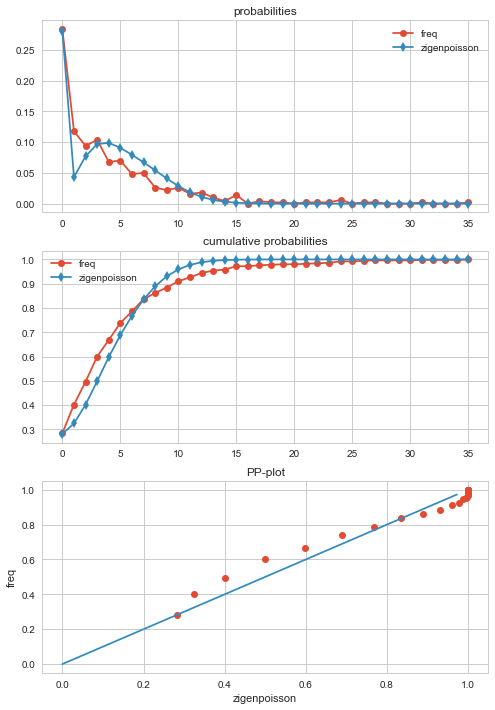

In [36]:
_= dia.plot_probs(freq, probsm_zip, label='zigenpoisson')

In [37]:
probs_zip.shape

(500, 36)

In [38]:
probsm_zip.shape

(36,)

In [39]:
features = ['x0', 'x1']
target = "target"

In [40]:
df[target].max()

35

In [41]:
df[target].min()

0

Given X, y and network parameters $\Theta$, we want to learn parameters of the zero inflated poisson models for each instance $x$ ie., $\lambda$ and $\mu$.

Once the model is trained, given an unknown $x_i$ model will provide two parameters $\lambda_i$ and $\mu_i$. From these parameters, we need to compute the expectations (which will be our count). 



In [42]:
# target∗log(target)−target+0.5∗log(2πtarget)
def sterling_approx(y):
    if y[0] == 0: return 0
    return y*np.log(y) - y + 0.5*np.log(np.pi*y)

In [43]:
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

class ZIPModelBC(nn.Module):
    def __init__(self, inputdim, hidden_dims, outputdim=2):
        super(ZIPModelBC, self).__init__()
        
        _layers = list()
        
        _layers.append(nn.Linear(inputdim, hidden_dims[0]))
        for h1, h2 in zip(hidden_dims[:], hidden_dims[1:]):
            _layers.append(nn.ReLU())
            _layers.append(nn.Linear(h1, h2))
            
        
        _layers.append(nn.ReLU())
        _layers.append(nn.Linear(h2, outputdim))
        
        self.layers = nn.Sequential(*_layers)
        

    def forward(self, x):
        out = self.layers(x)
        
        
        return out

In [44]:
import math

def zip_loss(inputx, targety, verbose=0):
    zero_idx = torch.as_tensor(np.where(targety==0)[0])
    nonzero_idx = torch.as_tensor(np.where(targety>0)[0])
    
    pix_zero = nn.Sigmoid()(inputx[zero_idx, 0])
    pix_nonzero = nn.Sigmoid()(inputx[nonzero_idx, 0])
    
    #print(inputx[:5])
    #print(pix_zero[:5])
    #print(pix_nonzero[:5])
    
    lambdax_zero = torch.exp(inputx[zero_idx, 1])
    lambdax_nonzero = torch.exp(inputx[nonzero_idx, 1])

    
    #zero_likelihoood = torch.log(pix[zero_idx] + (1-pix[zero_idx]).reshape(-1,1) * lambdax[zero_idx])   #where targety == 0
    zero_likelihood = torch.log(pix_zero + (1-pix_zero)*lambdax_zero)   #where targety == 0
    
    #print(targety[nonzero_idx].flatten())
    numerator1 = torch.pow(lambdax_nonzero, targety[nonzero_idx].flatten())
    numerator2 = torch.exp(-lambdax_nonzero)
    non_zero_num = (1-pix_nonzero) * numerator1 * numerator2
    
    '''https://en.wikipedia.org/wiki/Stirling%27s_approximation'''
    facts = [np.sqrt(2*np.pi)*np.power(i.item(), i.item()+0.5)*np.exp(-i.item()) for i in targety[nonzero_idx]]
    non_zero_denum = torch.as_tensor(facts, dtype=torch.float64)
    
    non_zero_likelihood = torch.log(non_zero_num / non_zero_denum)
    
    totalloss = torch.mean(zero_likelihood) + torch.mean(non_zero_likelihood) 
    
    #total_logloss = zero_loss + non_zero_loss
    
    if verbose:
        print(f'Input shape: {inputx.shape}')
        print(f'Target shape: {targety.shape}')
        
        print(f'pix_zero shape: {pix_zero.shape}')
        print(f'pix_nonzero shape: {pix_nonzero.shape}')
        
        print(f'lambdax_zero shape: {lambdax_zero.shape}')
        print(f'lambdax_nonzero shape: {lambdax_nonzero.shape}')
        
        print(f'zero_likelihood shape: {zero_likelihood.shape}')
        
        print(f'numerator1 shape: {numerator1.shape}')
        print(f'numerator2 shape: {numerator2.shape}')
        
        print(f'facts shape: {non_zero_denum.shape}')
        
        print(f'non_zero_loss shape: {non_zero_likelihood.shape}')
        
        print("zero_likelihood", torch.mean(zero_likelihood))
        print("non_zero_likelihood", torch.mean(non_zero_likelihood))
        print("total_loss", totalloss)
        
        
    return -totalloss

In [80]:
inputdim  = len(features)  # takes variable 'x' 
learningRate = 0.01
epochs = 2000

model = ZIPModelBC(inputdim, hidden_dims=[16,8,4])

In [81]:
model

ZIPModelBC(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [82]:
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

In [83]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    inputs = Variable(torch.tensor(df[features].astype(np.float32).values))
    targets = Variable(torch.tensor(df[target].astype(np.float32).values)).reshape(-1,1)

    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)
    
    #print(outputs[0:5])
    # get loss for the predicted output
    zloss = zip_loss(outputs, targets, verbose=0)
    
    # get gradients w.r.t to parameters
    zloss.backward()
    
    #print(f"grads:{model.linear.weight.grad}")
    
    # update parameters
    optimizer.step()
    #print(f"updated weights: {model.linear.weight}")
    
    if epoch%100==0:
        print('epoch {:3d} | loss {:.4f}'.format(epoch, zloss.item()))

print('epoch {:3d} | loss {:.4f}'.format(epoch, zloss.item()))
    #if epoch == 0: break

epoch   0 | loss 8.6750
epoch 100 | loss 1.5221
epoch 200 | loss 1.4963
epoch 300 | loss 1.4907
epoch 400 | loss 1.4886
epoch 500 | loss 1.4877
epoch 600 | loss 1.4872
epoch 700 | loss 1.4869
epoch 800 | loss 1.4867
epoch 900 | loss 1.4865
epoch 1000 | loss 1.4865
epoch 1100 | loss 1.4864
epoch 1200 | loss 1.4863
epoch 1300 | loss 1.4863
epoch 1400 | loss 1.4863
epoch 1500 | loss 1.4862
epoch 1600 | loss 1.4862
epoch 1700 | loss 1.4862
epoch 1800 | loss 1.4862
epoch 1900 | loss 1.4862
epoch 1999 | loss 1.4862


In [84]:
#test_inputs = Variable(torch.tensor(testX.astype(np.float32).values))
#test_targets = Variable(torch.tensor(testY.astype(np.float32).values)).reshape(-1,1)

preds = model(inputs)

In [85]:
lambdas = torch.exp(preds[..., 1])
lambdas[245:255]

tensor([4.9938, 4.9938, 4.9938, 4.9938, 4.9938, 7.8437, 7.8437, 7.8437, 7.8437,
        7.8437], grad_fn=<SliceBackward0>)

In [86]:
pis = nn.Sigmoid()(preds[..., 0])
pis[245:255]

tensor([6.5668e-05, 6.5668e-05, 6.5668e-05, 6.5668e-05, 6.5668e-05, 3.7351e-06,
        3.7351e-06, 3.7351e-06, 3.7351e-06, 3.7351e-06],
       grad_fn=<SliceBackward0>)

In [87]:
'''generate the predictions'''

probs = list()
for fr in range(36):
    pi = pis[fr].item()
    lambd = lambdas[fr].item()
    y = fr
    
    if y == 0: 
        pr = pi + (1-pi)*np.exp(-lambd)
    else:
        pr = (1-pi)*np.power(lambd, y)*np.exp(-lambd) / math.factorial(y)
        
    probs.append(pr)

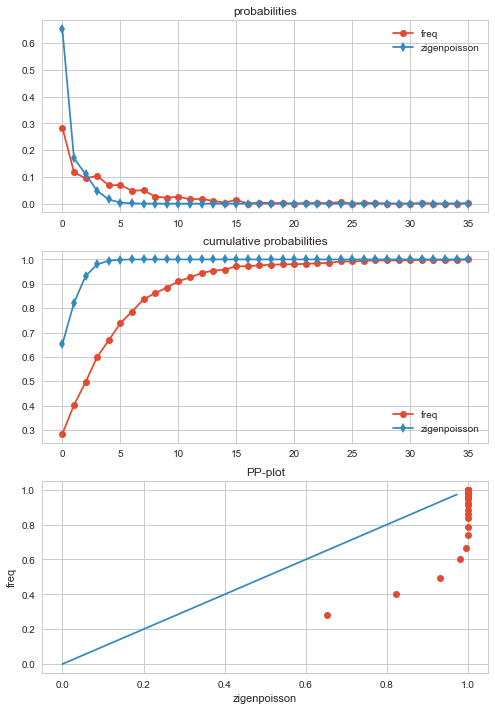

In [55]:
_= dia.plot_probs(freq, probs, label='zigenpoisson')

## Expectations

- Expectation of Poisson random variable:

$X\~ Poisson (\lambda), ~ \lambda >0, p(k) = e^{-\lambda} \lambda^k / k!$

$E[X]= \sum_{k=0}^{\infty} k * p(k) = \sum_{k=0}^{\infty} k * e^{-\lambda}  \frac{\lambda^k}{k!} = e^{-\lambda} \sum_{k=0}^{\infty} k \frac{\lambda^k}{k!}$

$= e^{-\lambda} \sum_{k=1}^{\infty} \frac{\lambda^k}{(k-1)!}= \lambda e^{-\lambda} \sum_{k=1}^{\infty} \frac{\lambda^(k-1)}{(k-1)!}$

Let, $k-1=j$

$= \lambda e^{-\lambda} \sum_{j=0}^{\infty} \frac{\lambda^(j)}{(j)!} = \lambda e^{-\lambda} \times e^{\lambda} = \lambda$


- Expectation of Bernoulli random variable:

$E[X] = \sum_x x\times p(x) = 0 \times (1-p) + 1 \times p = p$

In [56]:
'''generate the predictions: count'''

counts = list()
for fr in range(len(df)):
    pi = pis[fr].item()
    lambd = lambdas[fr].item()
    
    c = round(pi) * round(lambd)
        
    counts.append(c)

In [57]:
df.head()

,target,x0,x1
0,0,1.0,0.0
1,0,1.0,0.0
2,0,1.0,0.0
3,7,1.0,0.0
4,2,1.0,0.0


### ZIP using pytorch loss functions

- Poisson loss: loss(input, target) = input−target\times \log(input) + \log(target!)
    - when target = 0: loss(input, 0) = input 
    - here, input is model output i.e., $\log \lambda$ i.e., loss(input, 0) = $\log \lambda$

    - when target > 0:  loss(input, > 0) = $input−target\times \log(input) + \log(target!)$

- BCE loss: loss(input, target) = $target \times \log input + (1-target)\times \log(1-input)$
    - when traget = 0: $loss(input, 0) = \log(1-input)$
    - when traget = 1: $loss(input, 1) = \log(input)$
    
- ZIP loss:
    - when traget = 0: l1 = poisonloss + bceloss
    - when traget > 0: l2 = poisonloss * bceloss
    - loss = l1+l2

In [111]:
def ziploss_pytorch_fn(inputx, targety, verbose=0):
    sigpi = nn.Sigmoid()(inputx[..., 0]).reshape(-1,1)
    #print(sigpi.shape)
    piloss = nn.BCELoss()(sigpi, targety)
    
    lmbdaloss = nn.PoissonNLLLoss()(inputx[..., 0], targety)
    
    
    zero_mask = torch.zeros(targety.shape)
    #mask_nonzero = torch.where(y > 0, 1, 0)
    
    l1 = torch.where(targety==0, lmbdaloss, targety) + torch.where(targety==0, piloss, targety)
    #print(l1.shape)
    l2 = torch.where(targety>0, lmbdaloss, zero_mask) * torch.where(targety>0, piloss, zero_mask)
    #print(l2.shape)
    #lmbdaloss*mask_nonzero * piloss*mask_nonzero
    
    total_loss = l1 + l2
    return total_loss.mean()

In [153]:
inputdim  = len(features)  # takes variable 'x' 
learningRate = 0.0004
epochs = 2000

model = ZIPModelBC(inputdim, hidden_dims=[16,8,4])

In [154]:
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

In [155]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    inputs = Variable(torch.tensor(df[features].astype(np.float32).values))
    targets = Variable(torch.tensor(df[target].astype(np.float32).values)).reshape(-1,1)

    optimizer.zero_grad()
    
    #print(inputs.shape)
    #print(targets.shape)
    
    # get output from the model, given the inputs
    outputs = model(inputs)
    
    #print(outputs[0:5])
    # get loss for the predicted output
    #print(outputs.shape)
    zloss = ziploss_pytorch_fn(outputs, targets)
    
    # get gradients w.r.t to parameters
    zloss.backward()
    
    #print(f"grads:{model.linear.weight.grad}")
    
    # update parameters
    optimizer.step()
    #print(f"updated weights: {model.linear.weight}")
    
    if epoch % 100 == 0:
        print('epoch {:2d} | loss {:.4f}'.format(epoch, zloss.item()))
    
print('epoch {:2d} | loss {:.4f}'.format(epoch, zloss.item()))

epoch  0 | loss 12.2391
epoch 100 | loss 11.1119
epoch 200 | loss 10.2761
epoch 300 | loss 9.5446
epoch 400 | loss 8.9200
epoch 500 | loss 8.4477
epoch 600 | loss 8.1348
epoch 700 | loss 7.9541
epoch 800 | loss 7.8634
epoch 900 | loss 7.8238
epoch 1000 | loss 7.8087
epoch 1100 | loss 7.8037
epoch 1200 | loss 7.8022
epoch 1300 | loss 7.8018
epoch 1400 | loss 7.8017
epoch 1500 | loss 7.8017
epoch 1600 | loss 7.8017
epoch 1700 | loss 7.8017
epoch 1800 | loss 7.8017
epoch 1900 | loss 7.8017
epoch 1999 | loss 7.8017


In [156]:
preds = model(inputs)

In [157]:
lambdas = torch.exp(preds[..., 1])
lambdas[245:255]

tensor([0.7014, 0.7014, 0.7014, 0.7014, 0.7014, 0.7014, 0.7014, 0.7014, 0.7014,
        0.7014], grad_fn=<SliceBackward0>)

In [158]:
pis = nn.Sigmoid()(preds[..., 0])
pis[245:255]

tensor([0.6028, 0.6028, 0.6028, 0.6028, 0.6028, 0.6028, 0.6028, 0.6028, 0.6028,
        0.6028], grad_fn=<SliceBackward0>)

In [159]:
'''generate the predictions'''

probs = list()
for fr in range(36):
    pi = pis[fr].item()
    lambd = lambdas[fr].item()
    y = fr
    
    if y == 0: 
        pr = pi + (1-pi)*np.exp(-lambd)
    else:
        pr = (1-pi)*np.power(lambd, y)*np.exp(-lambd) / math.factorial(y)
        
    probs.append(pr)

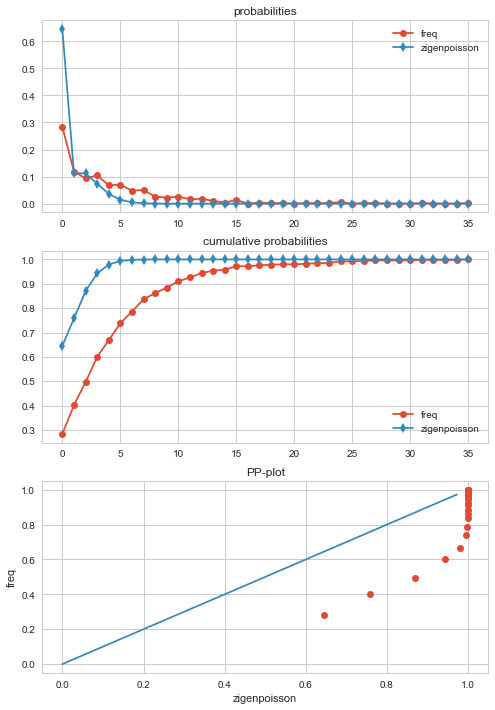

In [66]:
_= dia.plot_probs(freq, probs, label='zigenpoisson')